# Definitions

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display

# Definindo tamanhos de fonte globais para todos os gráficos
plt.rcParams.update({'font.size': 14})  # Aumentando o tamanho da fonte

# Estilos CSS para ajustar a exibição no Colab
display(HTML("<style>.container { width:100% !important; height:100% !important; }</style>"))

# Função para formatar os valores do eixo y
def y_formatter(x, pos):
    return f'{x:.3f}'

# AdaBoost

In [17]:
# Classe AdaBoost
class AdaBoost:
    def __init__(self, n_estimators=100, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.alphas = []
        self.models = []
        self.errors = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(X, y, sample_weight=weights)
            predictions = model.predict(X)

            incorrect = (predictions != y)
            error = np.dot(weights, incorrect) / np.sum(weights)
            self.errors.append(error)

            alpha = 0.5 * np.log((1 - error) / error)
            weights = weights * np.exp(alpha * incorrect)

            self.models.append(model)
            self.alphas.append(alpha)

    def predict(self, X):
        model_preds = np.array([model.predict(X) for model in self.models])
        weighted_preds = np.dot(self.alphas, model_preds)
        return np.sign(weighted_preds)

    def predict_proba(self, X):
        model_preds = np.array([model.predict(X) for model in self.models])
        weighted_preds = np.dot(self.alphas, model_preds)
        return 1 / (1 + np.exp(-weighted_preds))  # Usando função sigmoid para converter em probabilidades

# Load Data

In [18]:
# Função para carregar dados corretamente mapeados
def load_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
    df = pd.read_csv(url, header=None)

    # Mapeia os valores corretamente para números inteiros
    mapping = {'x': 0, 'o': 1, 'b': 2, 'positive': 1, 'negative': -1}
    df = df.applymap(lambda x: mapping[x])

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    return df, X, y

# Plot Functions

In [19]:
# Função para visualizar os tabuleiros Tic-Tac-Toe com dados originais, previsões e resultados
def visualize_boards_with_data(df, X, y, predictions, indices, n_estimators, accuracy):
    mapping = {0: 'X', 1: 'O', 2: ''}
    fig, axes = plt.subplots(4, 5, figsize=(16, 8))  # Criar uma matriz 4x5
    fig.suptitle(f'Number of Estimators = {n_estimators} | Accuracy={accuracy:.2f}', fontsize=20, y=0.9)

    for i, ax in enumerate(axes.flat):
        idx = indices[i]
        board = np.array(X[idx]).reshape(3, 3)
        board = np.vectorize(mapping.get)(board)
        table = ax.table(cellText=board, loc='center', bbox=[0.0, 0.5, 1.0, 0.8], cellLoc='center', edges='closed')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.0, 1.0)
        ax.axis('off')

        # Resultado verdadeiro
        true_result = 'Positive' if y[idx] == 1 else 'Negative'
        true_cell = ax.table(cellText=[[f'True: {true_result}']], bbox=[0.0, 0.1, 1.0, 0.30], cellLoc='center')
        true_cell.auto_set_font_size(False)
        true_cell.set_fontsize(10)

        # Resultado da predição
        pred_result = 'Positive' if predictions[idx] == 1 else 'Negative'
        pred_color = '#aaffaa' if y[idx] == predictions[idx] else '#ffaaaa'
        pred_cell = ax.table(cellText=[[f'Predicted: {pred_result}']], bbox=[0.0, -0.1, 1.0, 0.25], cellLoc='center')
        pred_cell.auto_set_font_size(False)
        pred_cell.set_fontsize(10)
        pred_cell[(0, 0)].set_facecolor(pred_color)

    plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.1, wspace=0.2, hspace=0.8)
    plt.show()

In [20]:
# Função para calcular a importância dos atributos
def feature_importances(models, alphas):
    total_importance = np.zeros(models[0].n_features_)
    for alpha, model in zip(alphas, models):
        total_importance += alpha * model.feature_importances_
    return total_importance / np.sum(total_importance)

In [21]:
# Função para plotar os erros de cada fold e as importâncias das features
def plot_fold_errors_and_importances(X, y, n_estimators):
    fig = plt.figure(figsize=(16, 4))  # Ajustando a figura

    feature_names = [
        'top-left', 'top-middle', 'top-right',
        'middle-left', 'middle-middle', 'middle-right',
        'bottom-left', 'bottom-middle', 'bottom-right'
    ]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    iteration_errors = []
    all_models = []
    fold_accuracies = []

    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

    ax_error = fig.add_subplot(gs[0, 0])  # Gráfico de erro na primeira coluna
    ax_importance = fig.add_subplot(gs[0, 1])  # Gráfico de importâncias na segunda coluna

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = AdaBoost(n_estimators=n_estimators, max_depth=2)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        error = 1 - accuracy_score(y_test, predictions)
        iteration_errors.append(model.errors)
        all_models.extend(model.models)
        fold_accuracies.append(accuracy_score(y_test, predictions))

        ax_error.plot(model.errors, label=f'Fold {fold + 1}', linewidth=2)

    mean_iteration_errors = np.mean(iteration_errors, axis=0)
    std_iteration_errors = np.std(iteration_errors, axis=0)
    mean_accuracy = np.mean(fold_accuracies)

    ax_error.plot(mean_iteration_errors, color='black', linewidth=2, label='Mean Error', linestyle='-')
    ax_error.fill_between(range(len(mean_iteration_errors)),
                          mean_iteration_errors - std_iteration_errors,
                          mean_iteration_errors + std_iteration_errors,
                          color='gray', alpha=0.5, label='Std Dev')

    ax_error.set_title(f'Error Rate per Iteration', fontweight='bold')
    ax_error.set_xlabel('Iteration', fontweight='bold')
    ax_error.set_ylabel('Error Rate', fontweight='bold')
    ax_error.yaxis.set_major_formatter(FuncFormatter(y_formatter))
    ax_error.legend()

    # Plotar importâncias das features
    importances = np.zeros(len(feature_names))
    for model in all_models:
        importances += model.feature_importances_

    importances /= len(all_models)
    indices = np.argsort(importances)[::-1]

    bar_width = 0.35
    ax_importance.bar(np.arange(len(importances)), importances[indices], color='blue', width=bar_width, edgecolor='grey')
    ax_importance.set_xticks(np.arange(len(importances)))
    ax_importance.set_xticklabels([feature_names[i] for i in indices], rotation=30, ha='right')
    ax_importance.set_xlim([-1, len(importances)])
    ax_importance.set_title('Feature Importances', fontweight='bold')
    ax_importance.yaxis.set_major_formatter(FuncFormatter(y_formatter))

    plt.tight_layout(pad=0.5)
    plt.show()

In [22]:
# Função para treinar e visualizar tabuleiros e gráficos para diferentes valores de n_estimators
def train_visualize_and_plot(n_estimators):
    # Carrega os dados
    df, X, y = load_data()

    # Divisão dos dados em treino e teste mantendo a proporção das classes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

    # Instancia e treina o modelo AdaBoost
    model = AdaBoost(n_estimators=n_estimators, max_depth=2)
    model.fit(X_train, y_train)

    # Avalia a acurácia do modelo nos dados de teste
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    # Seleciona aleatoriamente 12 índices com classe positive e 8 com classe negative
    positive_indices = np.random.choice(np.where(y_test == 1)[0], 12, replace=False)
    negative_indices = np.random.choice(np.where(y_test == -1)[0], 8, replace=False)
    selected_indices = np.concatenate([positive_indices, negative_indices])

    # Visualizar tabuleiros com predições e linhas originais da base de dados
    visualize_boards_with_data(df, X_test, y_test, predictions, selected_indices, n_estimators, accuracy)

    # Plotar gráficos de erros e importâncias das features
    plot_fold_errors_and_importances(X, y, n_estimators)

In [23]:
# Função para plotar os gráficos comparativos
def plot_comparative_errors_and_importances(X, y, estimators_list):
    fig = plt.figure(figsize=(16, 4))  # Ajustando a figura

    feature_names = [
        'top-left', 'top-middle', 'top-right',
        'middle-left', 'middle-middle', 'middle-right',
        'bottom-left', 'bottom-middle', 'bottom-right'
    ]

    all_mean_errors = []
    all_std_errors = []
    all_importances = []

    colors = plt.get_cmap('tab10').colors  # Utilizando a paleta de cores 'tab10'
    light_colors = ['#a6cee3', '#fb9a99', '#b2df8a']  # Tons mais claros das cores

    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

    ax_comparative_error = fig.add_subplot(gs[0, 0])  # Gráfico de erro nas primeiras duas colunas
    ax_comparative_importance = fig.add_subplot(gs[0, 1])  # Gráfico de importâncias na terceira coluna

    for idx, n_estimators in enumerate(estimators_list):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        iteration_errors = []

        all_models = []
        fold_accuracies = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = AdaBoost(n_estimators=n_estimators, max_depth=2)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)

            error = 1 - accuracy_score(y_test, predictions)
            iteration_errors.append(model.errors)
            all_models.extend(model.models)
            fold_accuracies.append(accuracy_score(y_test, predictions))

        mean_iteration_errors = np.mean(iteration_errors, axis=0)
        std_iteration_errors = np.std(iteration_errors, axis=0)
        mean_accuracy = np.mean(fold_accuracies)

        all_mean_errors.append(mean_iteration_errors)
        all_std_errors.append(std_iteration_errors)

        importances = np.zeros(len(feature_names))
        for model in all_models:
            importances += model.feature_importances_

        importances /= len(all_models)
        all_importances.append(importances)

    # Plotar erros médios comparativos na ordem desejada
    for idx in [2, 1, 0]:  # Ordem: 100, 200, 50
        n_estimators = estimators_list[idx]
        color = colors[idx]
        light_color = light_colors[idx]
        mean_iteration_errors = all_mean_errors[idx]
        std_iteration_errors = all_std_errors[idx]

        ax_comparative_error.plot(mean_iteration_errors, label=f'n_estimators={n_estimators}', color=color, linewidth=4)
        ax_comparative_error.fill_between(range(len(mean_iteration_errors)),
                                          mean_iteration_errors - std_iteration_errors,
                                          mean_iteration_errors + std_iteration_errors,
                                          color=light_color, alpha=0.5)

    ax_comparative_error.set_title('Comparative Error Rates per Iteration', fontweight='bold')
    ax_comparative_error.set_xlabel('Iteration', fontweight='bold')
    ax_comparative_error.set_ylabel('Error Rate', fontweight='bold')
    ax_comparative_error.yaxis.set_major_formatter(FuncFormatter(y_formatter))
    ax_comparative_error.legend()

    # Plotar importâncias das features comparativas
    for idx, n_estimators in enumerate(estimators_list):
        color = colors[idx]
        importances = all_importances[idx]
        indices = np.argsort(importances)[::-1]

        bar_width = 0.25
        r = np.arange(len(importances)) + bar_width * idx
        ax_comparative_importance.bar(r, importances[indices], color=color, width=bar_width, edgecolor='grey', label=f'n_estimators={n_estimators}')

    ax_comparative_importance.set_xticks(np.arange(len(importances)) + bar_width)
    ax_comparative_importance.set_xticklabels([feature_names[i] for i in np.argsort(importances)[::-1]], rotation=30, ha='right')
    ax_comparative_importance.set_xlim([-1, len(importances)])
    ax_comparative_importance.set_title('Comparative Feature Importances', fontweight='bold')
    ax_comparative_importance.yaxis.set_major_formatter(FuncFormatter(y_formatter))
    ax_comparative_importance.legend()

    plt.tight_layout(pad=0.5)
    plt.show()

In [24]:
# Função para comparar a evolução da acurácia variando n_estimators e max_depth
def compare_accuracy_evolution(X, y, estimators_list, depths_list):
    fig, ax = plt.subplots(figsize=(12, 6))  # Ajustando a figura (diminuindo a altura)

    colors = plt.get_cmap('tab10').colors  # Utilizando a paleta de cores 'tab10'
    markers = ['o', 's', 'D', '^', 'v']  # Diferentes marcadores para max_depth

    for j, max_depth in enumerate(depths_list):
        mean_accuracies = []
        std_accuracies = []

        for i, n_estimators in enumerate(estimators_list):
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            fold_accuracies = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model = AdaBoost(n_estimators=n_estimators, max_depth=max_depth)
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)
                fold_accuracies.append(accuracy_score(y_test, predictions))

            mean_accuracy = np.mean(fold_accuracies)
            std_accuracy = np.std(fold_accuracies)

            mean_accuracies.append(mean_accuracy)
            std_accuracies.append(std_accuracy)

            color = colors[j % len(colors)]
            marker = markers[j % len(markers)]

            ax.errorbar(n_estimators, mean_accuracy, yerr=std_accuracy, fmt=marker, color=color, capsize=5)

        # Adicionando linhas que ligam os centros de cada max_depth
        ax.plot(estimators_list, mean_accuracies, linestyle='-', color=colors[j % len(colors)], alpha=0.7, label=f'max_depth={max_depth}')

    ax.set_title('Accuracy Evolution with n_estimators and max_depth', fontweight='bold')
    ax.set_xlabel('n_estimators', fontweight='bold')
    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Ajustando a legenda para fora do gráfico
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='max_depth')

    plt.tight_layout()
    plt.show()

# Results

## N = 50

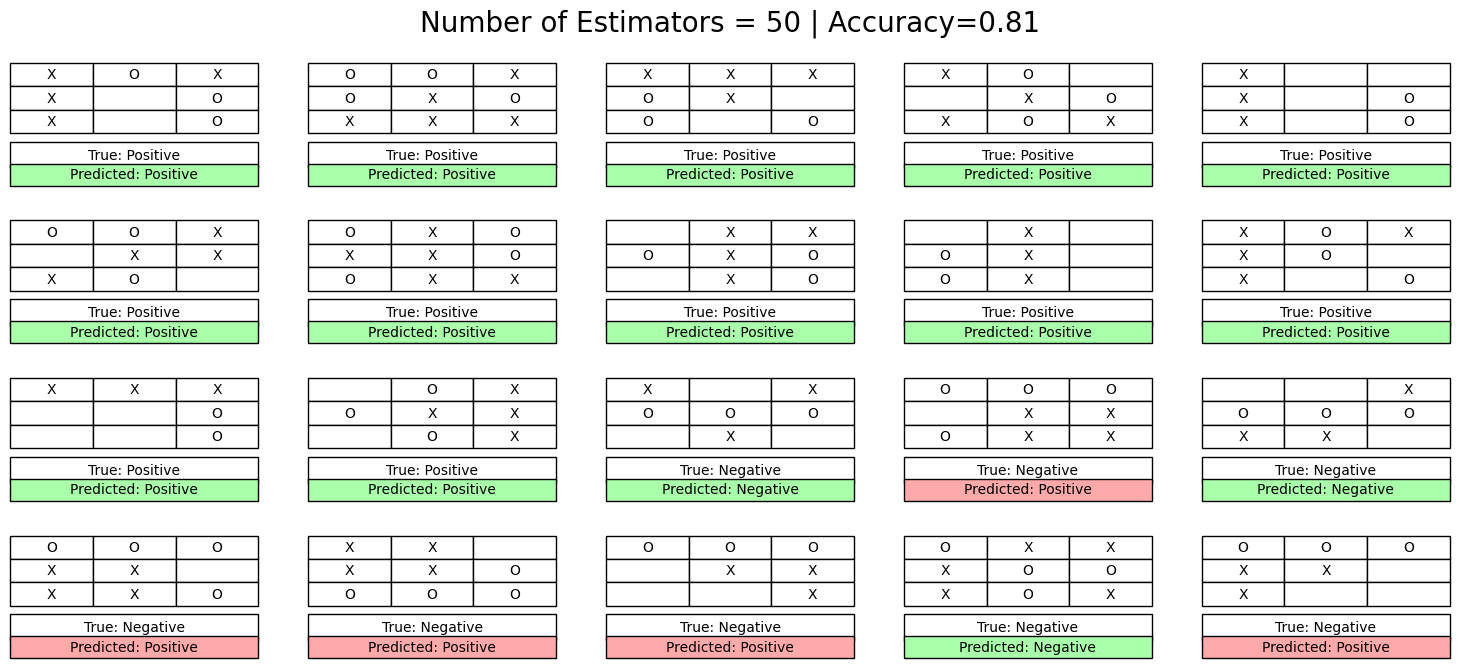

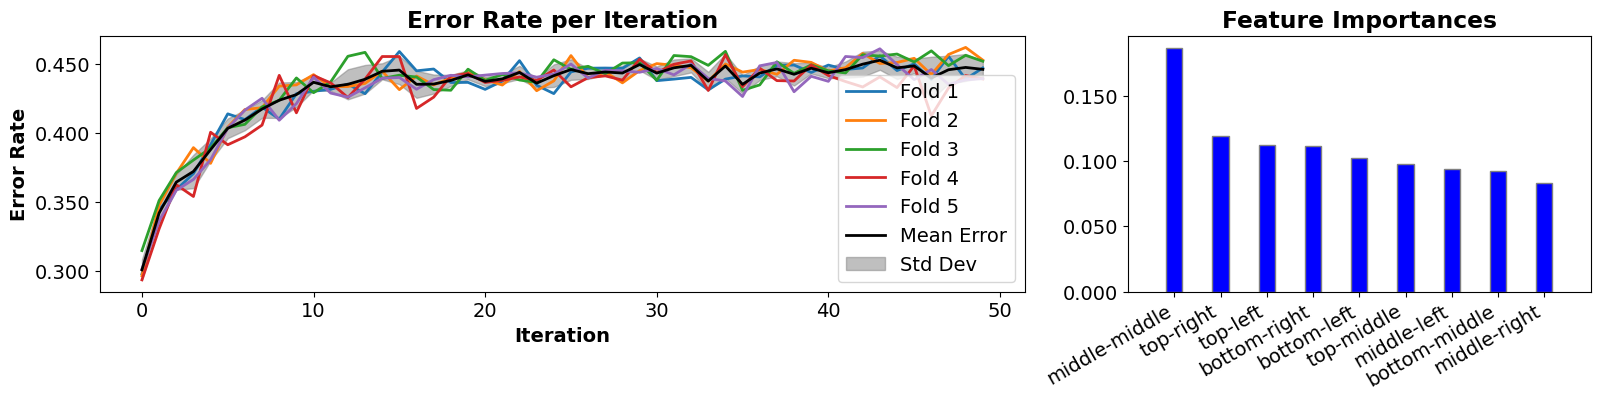

In [10]:
# Executar para n_estimators = 50
train_visualize_and_plot(50)

## N = 100

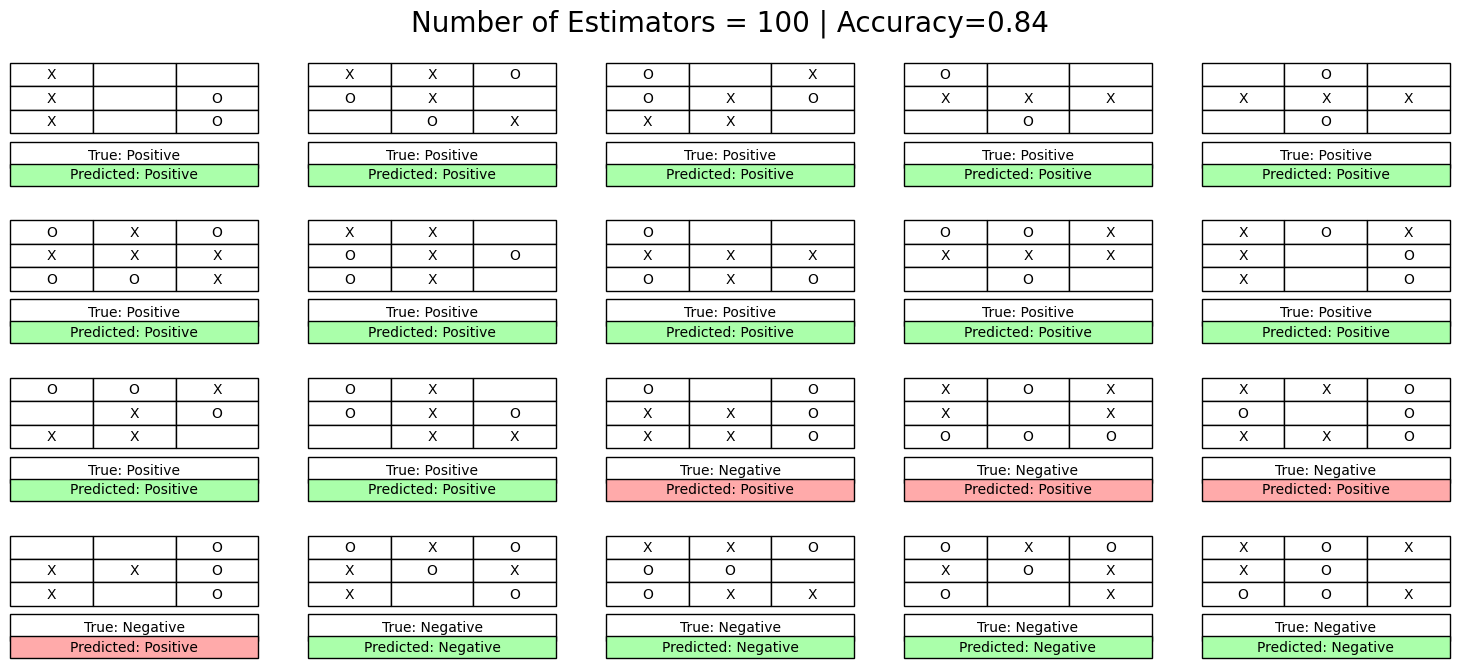

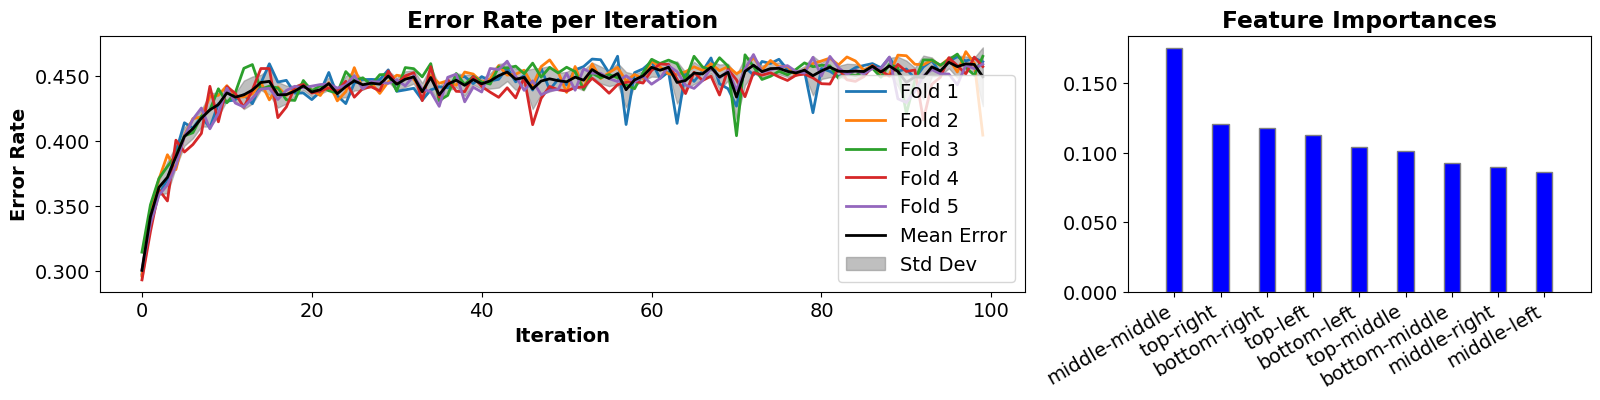

In [11]:
# Executar para n_estimators = 100
train_visualize_and_plot(100)

## N = 200

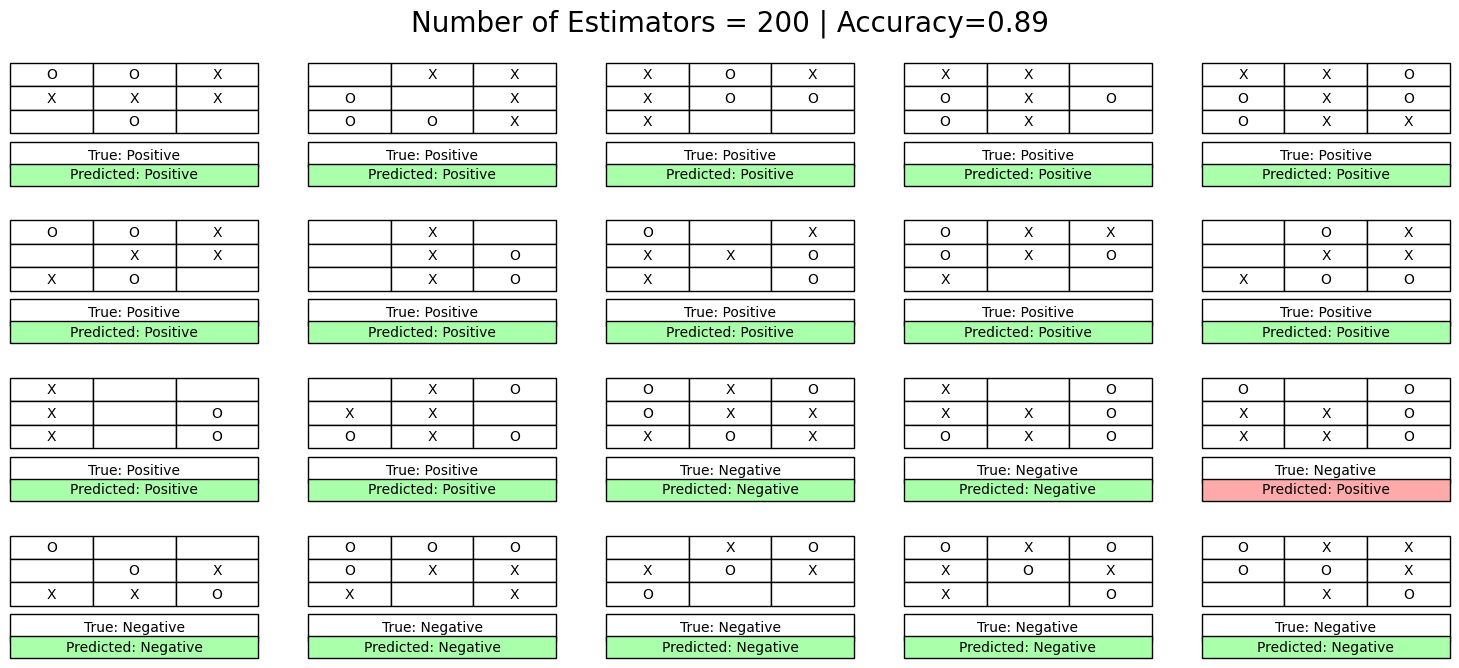

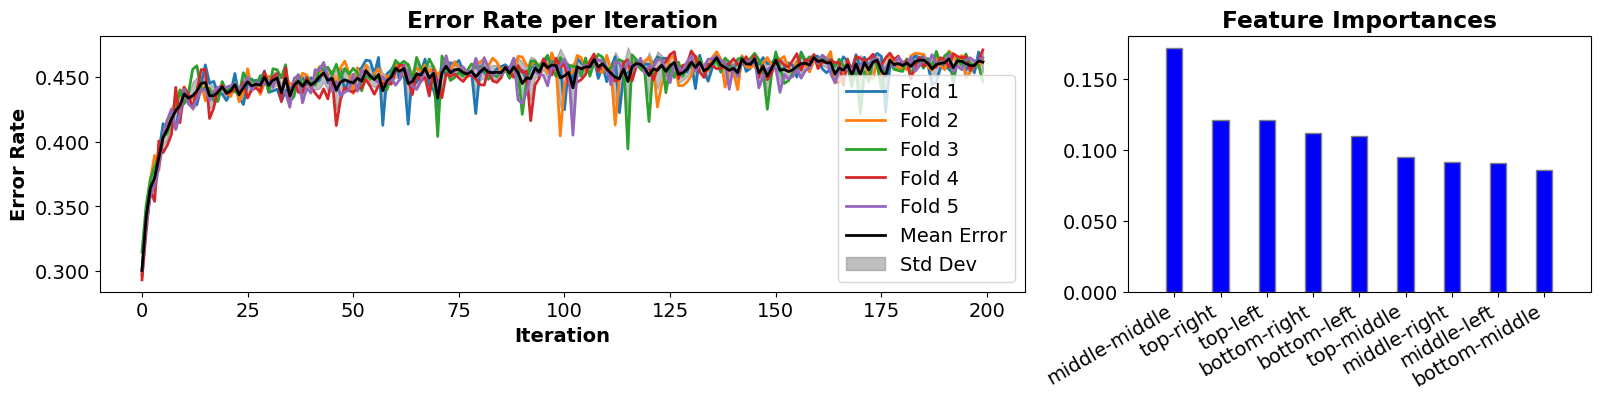

In [12]:
# Executar para n_estimators = 200
train_visualize_and_plot(200)

## Comparisons

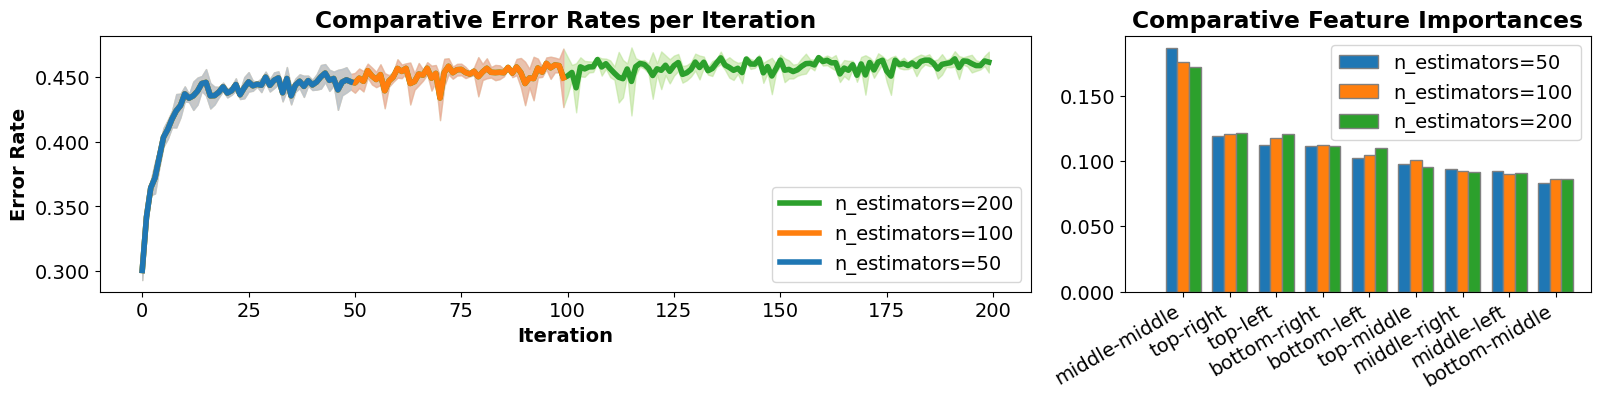

In [31]:
# Carrega os dados
df, X, y = load_data()

# Realizar gráficos comparativos com diferentes números de estimadores
estimators_list = [50, 100, 200]
plot_comparative_errors_and_importances(X, y, estimators_list)

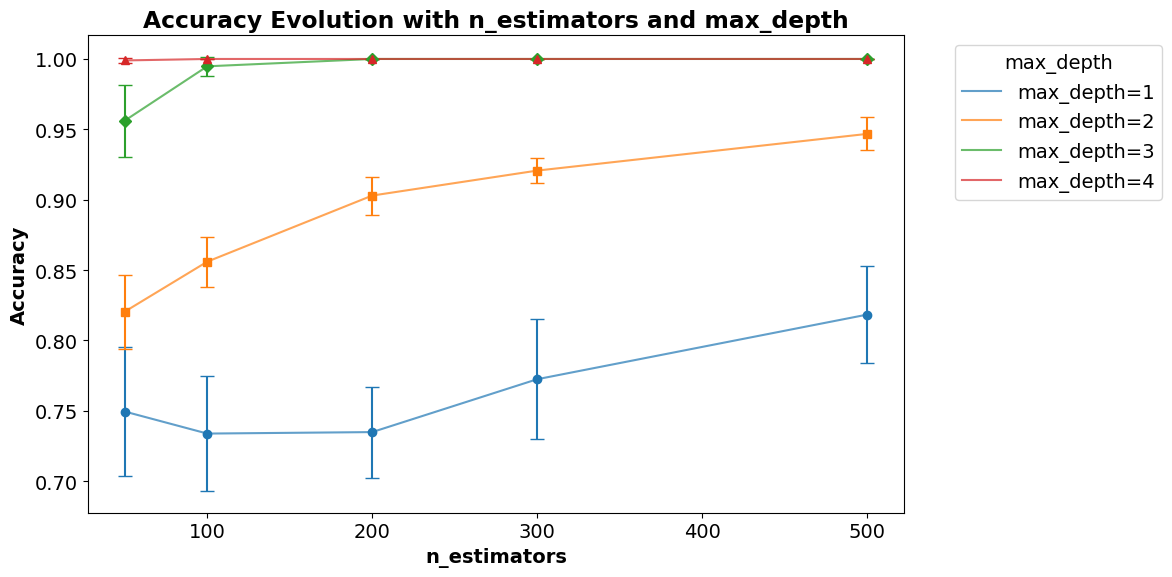

In [32]:
# Listas de valores para n_estimators e max_depth
estimators_list = [50, 100, 200, 300, 500]
depths_list = [1, 2, 3, 4]

# Comparar a evolução da acurácia variando n_estimators e max_depth
compare_accuracy_evolution(X, y, estimators_list, depths_list)

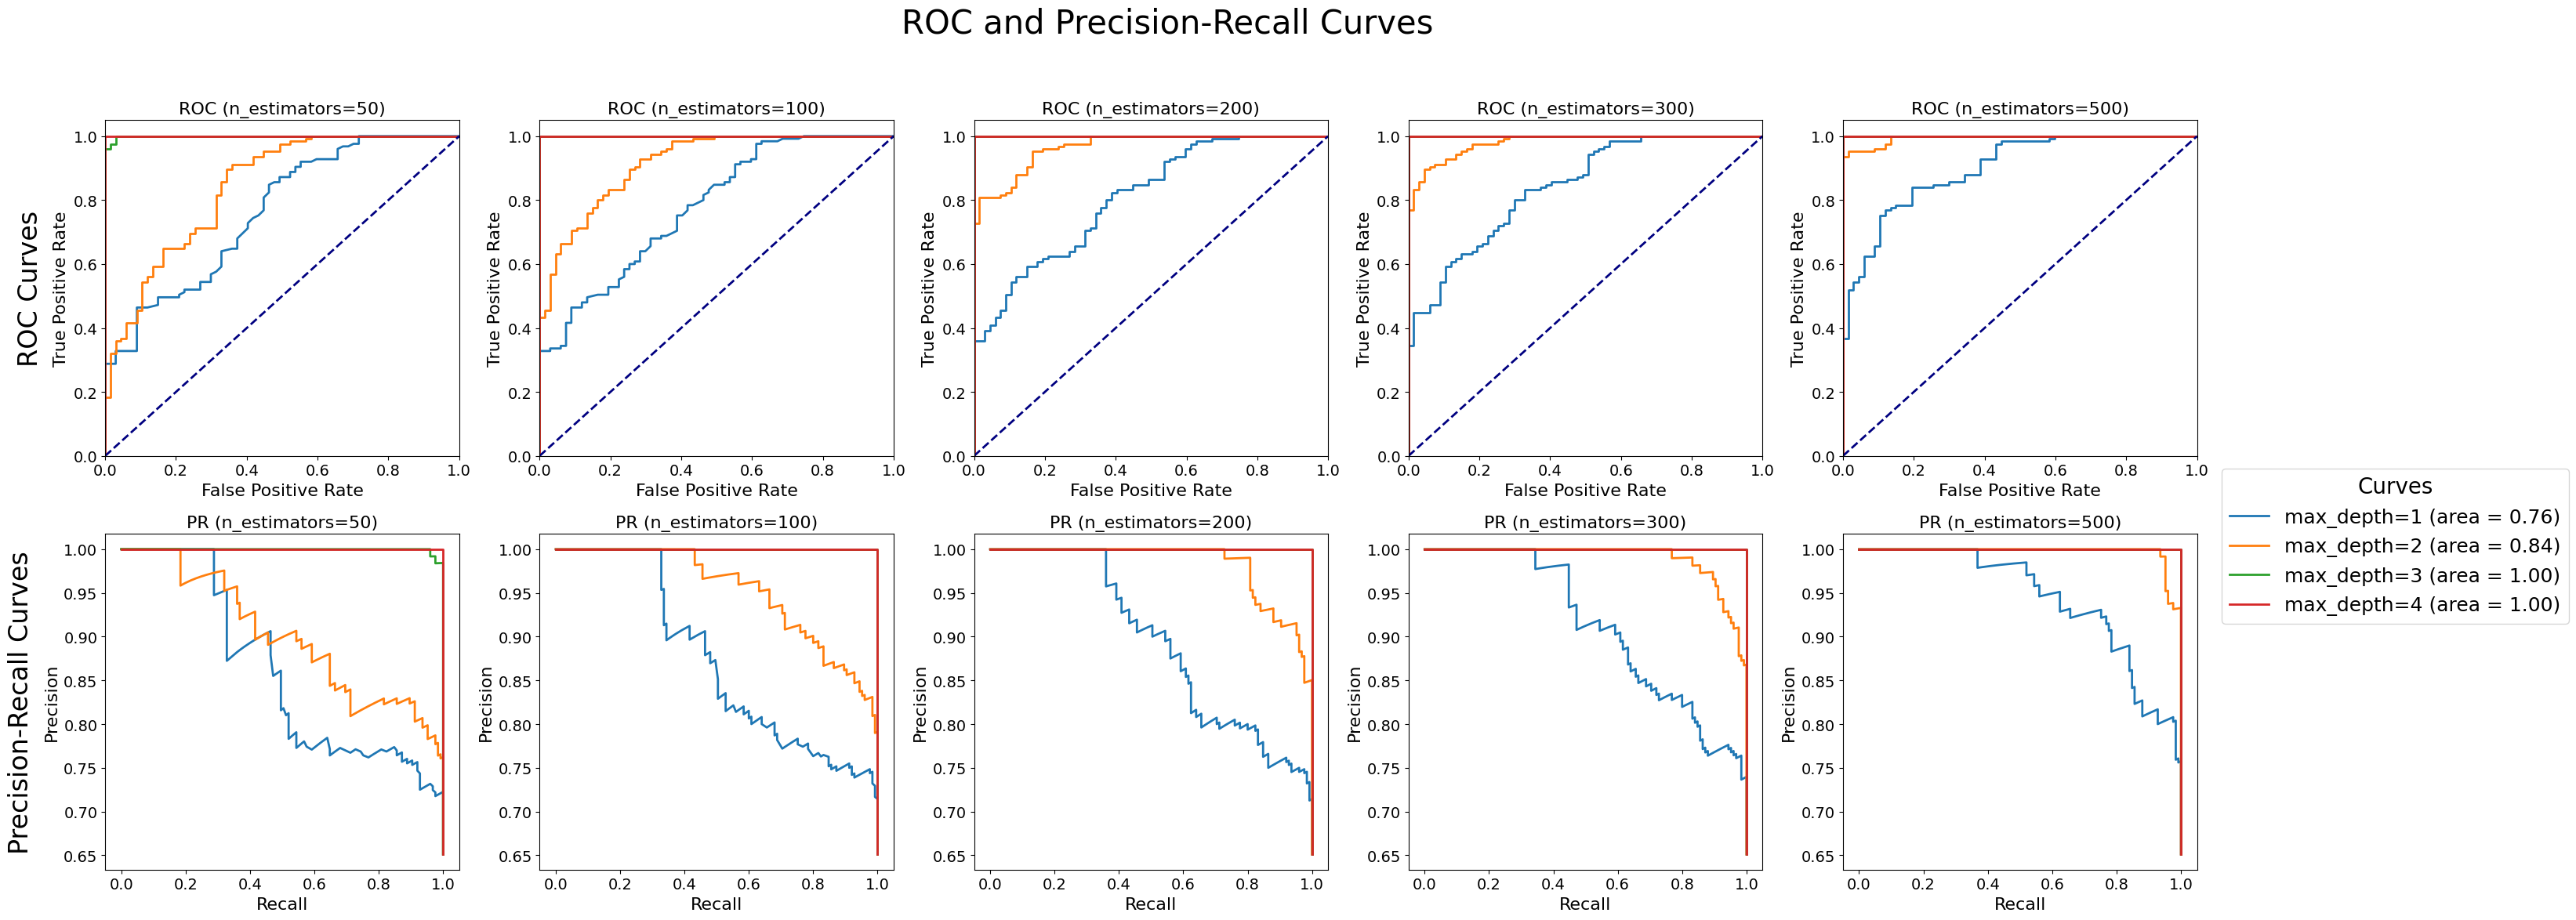

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

def plot_roc_pr_curves_grouped(y_true, y_scores_dict, n_estimators, ax, col):
    # Plotar todas as curvas ROC
    for max_depth, y_scores in y_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax[0, col].plot(fpr, tpr, lw=2, label=f'max_depth={max_depth} (area = {roc_auc:.2f})')

    ax[0, col].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0, col].set_xlim([0.0, 1.0])
    ax[0, col].set_ylim([0.0, 1.05])
    ax[0, col].set_xlabel('False Positive Rate', fontsize=16)
    ax[0, col].set_ylabel('True Positive Rate', fontsize=16)
    ax[0, col].set_title(f'ROC (n_estimators={n_estimators})', fontsize=16)

    # Plotar todas as curvas Precisão-Revocação
    for max_depth, y_scores in y_scores_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ax[1, col].plot(recall, precision, lw=2, label=f'max_depth={max_depth}')

    ax[1, col].set_xlabel('Recall', fontsize=16)
    ax[1, col].set_ylabel('Precision', fontsize=16)
    ax[1, col].set_title(f'PR (n_estimators={n_estimators})', fontsize=16)

# Carrega os dados
df, X, y = load_data()

# Listas de valores para n_estimators e max_depth
estimators_list = [50, 100, 200, 300, 500]
depths_list = [1, 2, 3, 4]

# Criar a figura com 2 linhas e 5 colunas de subplots, com largura ajustada
fig, ax = plt.subplots(2, 5, figsize=(30, 12))

# Adicionar títulos das linhas
fig.suptitle('ROC and Precision-Recall Curves', fontsize=30)
ax[0, 0].annotate('ROC Curves', xy=(0, 0.5), xytext=(-ax[0, 0].yaxis.labelpad - 5, 0),
                  xycoords=ax[0, 0].yaxis.label, textcoords='offset points',
                  ha='right', va='center', rotation=90, fontsize=24)
ax[1, 0].annotate('Precision-Recall Curves', xy=(0, 0.5), xytext=(-ax[1, 0].yaxis.labelpad - 5, 0),
                  xycoords=ax[1, 0].yaxis.label, textcoords='offset points',
                  ha='right', va='center', rotation=90, fontsize=24)

# Loop para treinar e gerar curvas ROC e Precisão-Revocação para todas as combinações
for i, n_estimators in enumerate(estimators_list):
    y_scores_dict = {}
    for max_depth in depths_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Instanciando e treinando o modelo AdaBoost
        ada = AdaBoost(n_estimators=n_estimators, max_depth=max_depth)
        ada.fit(X_train, y_train)

        # Obtendo previsões e probabilidades
        y_scores = ada.predict_proba(X_test)
        if y_scores.ndim == 2:
            y_scores = y_scores[:, 1]
        y_scores_dict[max_depth] = y_scores

    # Plotando curvas ROC e Precisão-Revocação lado a lado agrupadas por n_estimators
    plot_roc_pr_curves_grouped(y_test, y_scores_dict, n_estimators, ax, i)

# Adicionar legendas gerais para cada linha
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), title='Curves', fontsize=18, title_fontsize=20)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


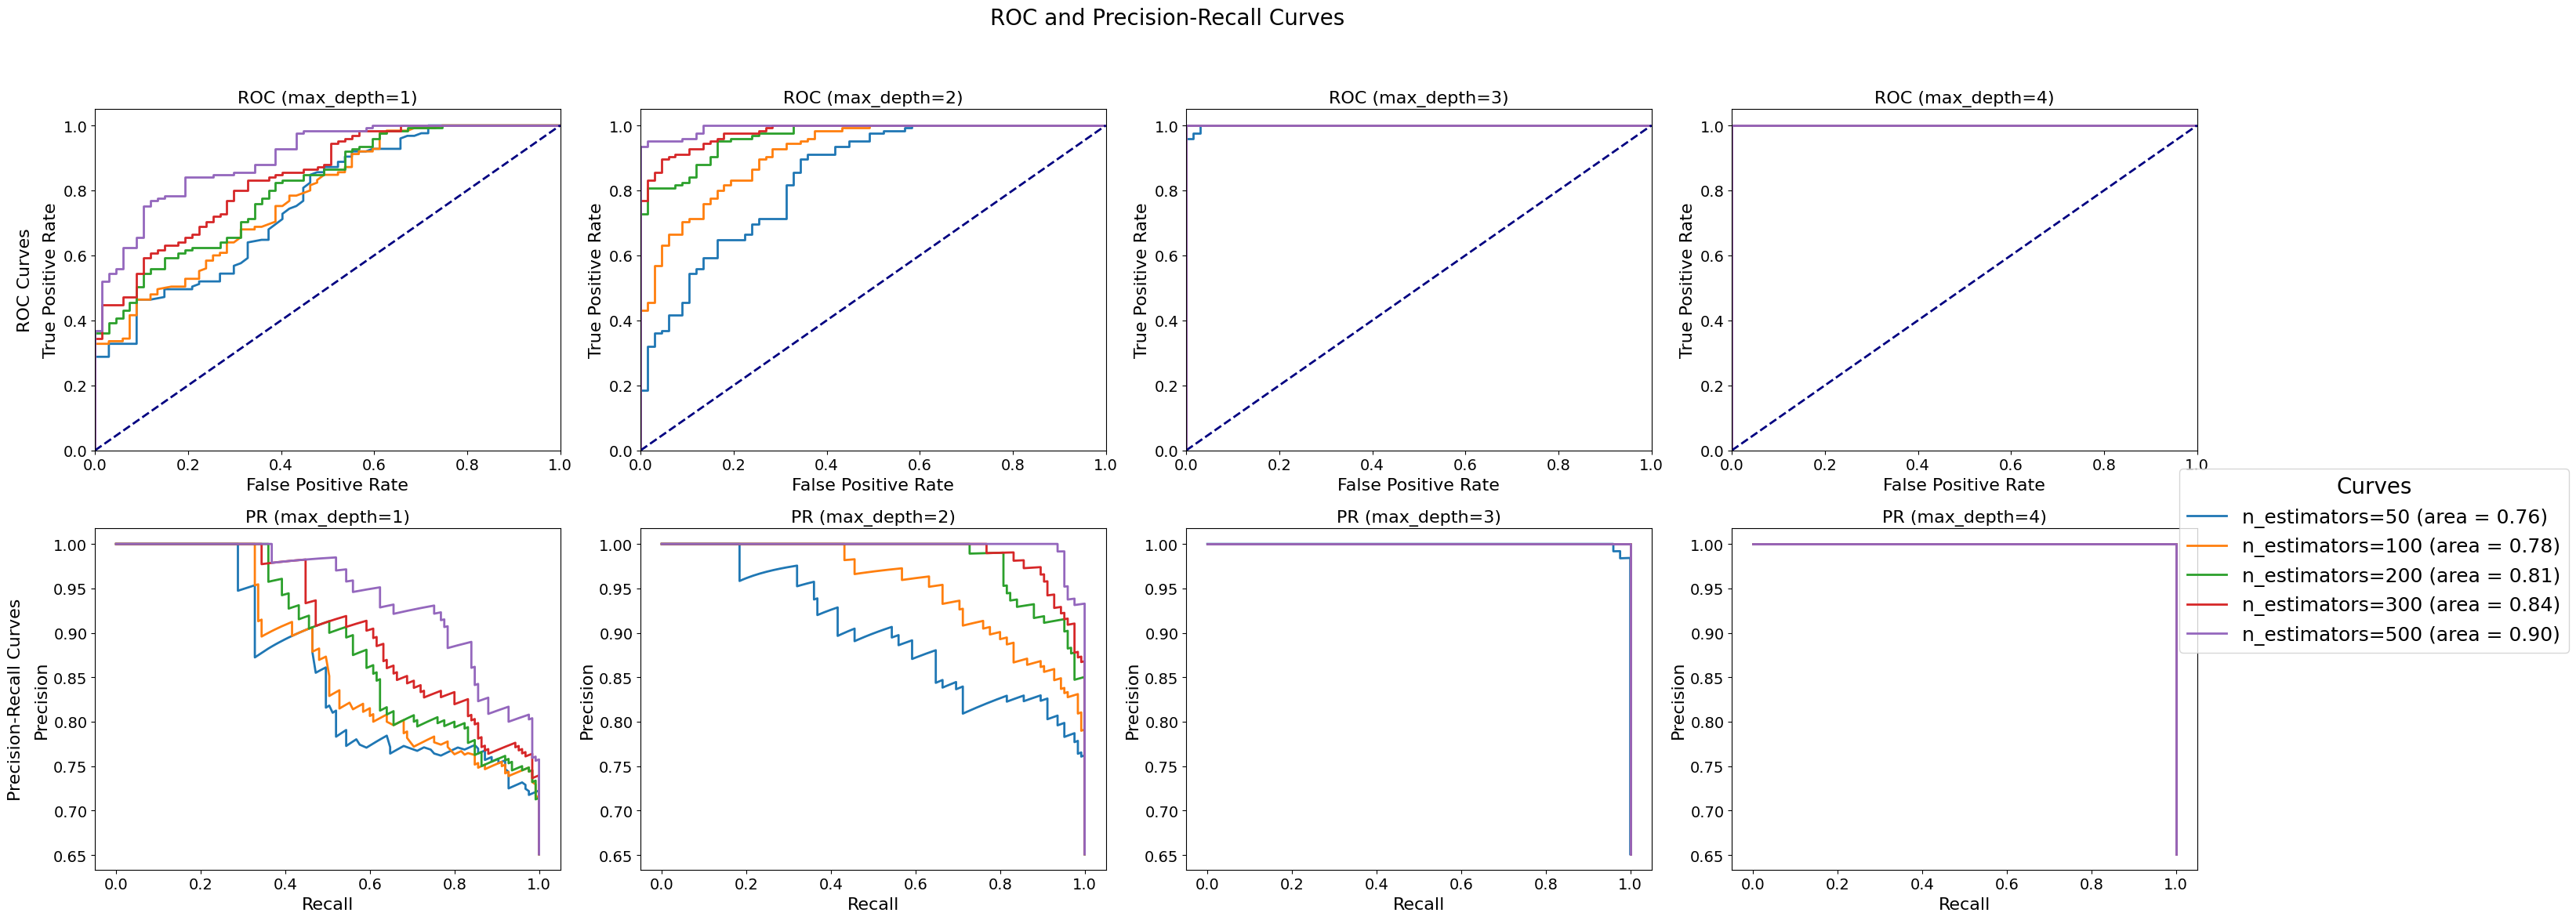

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

def plot_roc_pr_curves_grouped(y_true, y_scores_dict, max_depth, ax, col):
    # Plotar todas as curvas ROC
    for n_estimators, y_scores in y_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax[0, col].plot(fpr, tpr, lw=2, label=f'n_estimators={n_estimators} (area = {roc_auc:.2f})')

    ax[0, col].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0, col].set_xlim([0.0, 1.0])
    ax[0, col].set_ylim([0.0, 1.05])
    ax[0, col].set_xlabel('False Positive Rate', fontsize=16)
    ax[0, col].set_ylabel('True Positive Rate', fontsize=16)
    ax[0, col].set_title(f'ROC (max_depth={max_depth})', fontsize=16)

    # Plotar todas as curvas Precisão-Revocação
    for n_estimators, y_scores in y_scores_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ax[1, col].plot(recall, precision, lw=2, label=f'n_estimators={n_estimators}')

    ax[1, col].set_xlabel('Recall', fontsize=16)
    ax[1, col].set_ylabel('Precision', fontsize=16)
    ax[1, col].set_title(f'PR (max_depth={max_depth})', fontsize=16)

# Carrega os dados
df, X, y = load_data()

# Listas de valores para n_estimators e max_depth
estimators_list = [50, 100, 200, 300, 500]
depths_list = [1, 2, 3, 4]

# Criar a figura com 2 linhas e 5 colunas de subplots, com largura ajustada
fig, ax = plt.subplots(2, 4, figsize=(30, 12))

# Adicionar títulos das linhas
fig.suptitle('ROC and Precision-Recall Curves', fontsize=20)
ax[0, 0].annotate('ROC Curves', xy=(0, 0.5), xytext=(-ax[0, 0].yaxis.labelpad - 5, 0),
                  xycoords=ax[0, 0].yaxis.label, textcoords='offset points',
                  ha='right', va='center', rotation=90, fontsize=16)
ax[1, 0].annotate('Precision-Recall Curves', xy=(0, 0.5), xytext=(-ax[1, 0].yaxis.labelpad - 5, 0),
                  xycoords=ax[1, 0].yaxis.label, textcoords='offset points',
                  ha='right', va='center', rotation=90, fontsize=16)

# Loop para treinar e gerar curvas ROC e Precisão-Revocação para todas as combinações
for i, max_depth in enumerate(depths_list):
    y_scores_dict = {}
    for n_estimators in estimators_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Instanciando e treinando o modelo AdaBoost
        ada = AdaBoost(n_estimators=n_estimators, max_depth=max_depth)
        ada.fit(X_train, y_train)

        # Obtendo previsões e probabilidades
        y_scores = ada.predict_proba(X_test)
        y_scores_dict[n_estimators] = y_scores

    # Plotando curvas ROC e Precisão-Revocação lado a lado agrupadas por max_depth
    plot_roc_pr_curves_grouped(y_test, y_scores_dict, max_depth, ax, i)

# Adicionar legendas gerais para cada linha
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), title='Curves', fontsize=18, title_fontsize=20)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


# Analysis

For each number of estimators, there are a few examples of boards showing the prediction and if it is correct or not, the error evolution per iteration and de importance of each feature.

At the end, there are a few comparisons, showing that the error per iteration are closely related and they tend to a limiar of 45% and the feature importances have close values.

There is an interesting fact, that the error increase as the iterations occur. Despite being counterintuitive at a first glance, decision trees tend to overfit the training data, and it is exactly what happened. Despite the error increase, it occurs at the very beginning, stabilizing very quickly around 45%.

The accuracy evolution show that the depth is a really important parameter, reaching a considerable accuracy at only a depth of 3.

Later, there are shown a few graphs of the ROC and Precision-Recall curves, first grouped by the number of estimators and then by the max depth. When analyzing by number of estimators, there can be seen that the evolution occurs slowly as the parameter increases, which opposes to max depth groups, which clearly shows the fast evolution as the depth increases, reaching a considerable reasult with only at depth 3, which agrees with the accuracy part of the analysis.